# Transfer learning Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two mainbenefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural networking neural architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Download and becoming one with the data

In [1]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unip the download file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-08-22 10:19:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.121.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   265MB/s    in 0.6s    

2023-08-22 10:19:56 (265 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} .')

There are 2 directories and 0 images in 10_food_classes_10_percent .
There are 10 directories and 0 images in 10_food_classes_10_percent/train .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak .
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger

## Create a data loaders (preparing the data)

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images: ')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print('Testing images: ')
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functuonality you can add yo your models to be performed during or after training.

Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoinnt callbak
* Stopping a model from training (befores it trains too long and overfits) with the EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%m%s')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

## Creating models using tensorflow hub

Tensorflow hub has some pre-trained models


In [5]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [6]:
# Import dependexies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Make a function to create a model
def create_model(model_url, num_classes=10):
  """
  Takes a TF_hub url and creates a Keras Sequential model

  Args:
    model_url(string): Tensorflow_hub URL
    num_classes(int): Number of output neurns, default 10.

  Returns:
    An uncompiled Keras Sequential model
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #freeze the already learned patterns
                                           name='Feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,))
  # Create our own model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Create ResNet TensorFlow Hub Feature Extraction model

In [8]:
# Create a ResNet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
# Compile our ResNet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20230822-10081692699616
Epoch 1/5
24/24 [==============================] - 27s 610ms/step - loss: 1.9429 - accuracy: 0.3600 - val_loss: 1.2219 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 13s 543ms/step - loss: 0.9273 - accuracy: 0.7360 - val_loss: 0.8585 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 13s 546ms/step - loss: 0.6150 - accuracy: 0.8293 - val_loss: 0.7661 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 13s 542ms/step - loss: 0.4729 - accuracy: 0.8707 - val_loss: 0.7210 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 10s 432ms/step - loss: 0.3722 - accuracy: 0.9253 - val_loss: 0.6869 - val_accuracy: 0.7772


In [12]:
# Let's create a function to plot the losses curvess
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  acc = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_acc = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, acc, label='training accuracy')
  plt.plot(epochs, val_acc, label='validation accuracy')
  plt.title('accurancy')
  plt.xlabel('epochs')
  plt.legend()


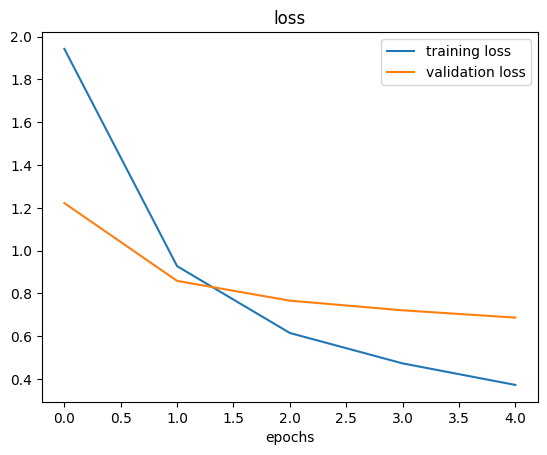

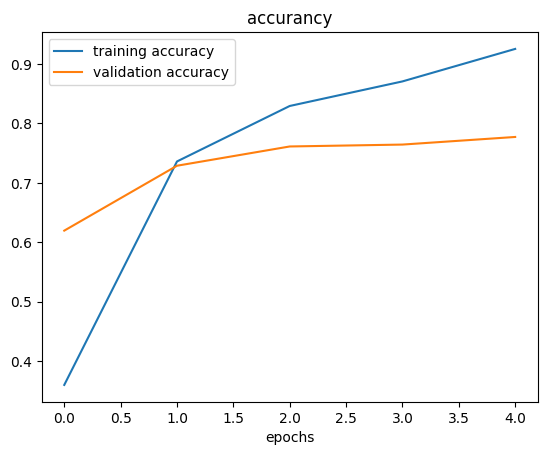

In [13]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [14]:
efficientnet_model = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [15]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [16]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [17]:
effi_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='efficientnetb0')])

Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20230822-10081692699708
Epoch 1/5
24/24 [==============================] - 28s 497ms/step - loss: 1.8576 - accuracy: 0.4267 - val_loss: 1.3144 - val_accuracy: 0.7212
Epoch 2/5
24/24 [==============================] - 10s 413ms/step - loss: 1.0692 - accuracy: 0.7813 - val_loss: 0.8739 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.7578 - accuracy: 0.8453 - val_loss: 0.7032 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 12s 533ms/step - loss: 0.6090 - accuracy: 0.8787 - val_loss: 0.6129 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 12s 535ms/step - loss: 0.5129 - accuracy: 0.8960 - val_loss: 0.5611 - val_accuracy: 0.8560


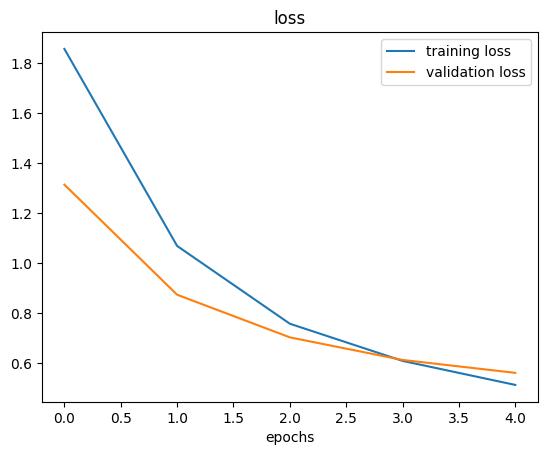

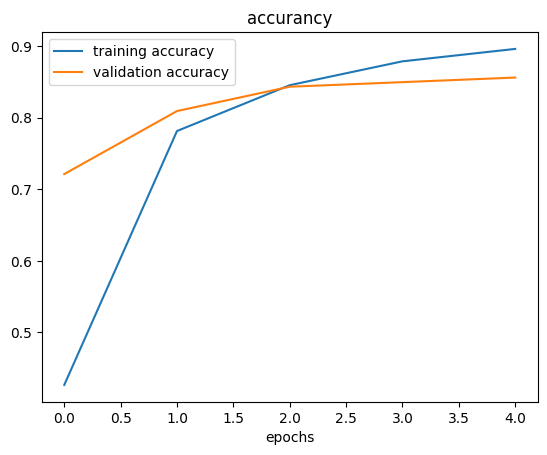

In [18]:
plot_loss_curves(effi_history)

## Different types of transfer learning
* **As is**- using an existing model without changes
* **Feature extraction** - use the prelearned patterns of an existing model and adjusting the output layers to the problem
* **Fine-tuning** - use the prelearned patterns of an existing model and fine-tuning many or all of the underlying layers